In [1]:
from BRScraper import nba
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc, recall_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer


In [2]:
# loading in the datasets
train_df = pd.read_csv('nba_combined_1980_2015_with_Team_Rank.csv')
test_df = pd.read_csv('nba_combined_2016_2024_with_Team_Rank.csv')

# bringing in features from the datasets and selecting target
features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%',
    'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
    'TOV', 'PTS', 'TS%', 'EFF', 'Team_Rank', 'Made_Playoffs'
]
target = 'Nominated'

# preparing the data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# handeling missing values and scaling features if necessary
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# applying the transformations to the train and test sets
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=features)

# training the DummyClassifier model
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_scaled, y_train)

# validatiing the model
y_pred = dummy_clf.predict(X_test_scaled)
y_pred_proba = dummy_clf.predict_proba(X_test_scaled)[:, 1]

# printing out evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4879
           1       0.05      0.09      0.06        95

    accuracy                           0.94      4974
   macro avg       0.51      0.53      0.52      4974
weighted avg       0.96      0.94      0.95      4974

ROC-AUC Score: 0.528


An accuracy of 0.945 means the model is correctly predicting about 94.5% of the time. Which is pretty high to begin with. This is likely becuase mvp winners and nominees is a very small set of players in comparison to the rest of the league. (we're dealing with an imbalanced dataset)

Recall measures the ability of your model to find all the actual positive cases. A recall of 0.095 means our model only identifies about 9.5% of the actual positive cases.

ROC-AUC measures the ability of the model to distinguish between positive and negative classes. An ROC-AUC of 0.528 is very close to 0.5, which is the score we would expect from a random classifier.

Now lets try to predict the top 5 nominees for the MVP award in the 2022-23 season

Top 5 Players Likely to Win the League MVP Award (2023-24 Season):
        Player Team  PTS  EFF  Team_Rank  MVP_Prob
    JD Davison  BOS  2.0 0.44          1       1.0
    Cam Thomas  BRK 22.5 0.25         22       1.0
Scottie Barnes  TOR 19.9 0.42         25       1.0
    Kevin Knox  DET  7.2 0.22         30       1.0
 Johnny Juzang  UTA  7.2 0.33         23       1.0

The actual Top 5 Players nominated for League MVP Award (2023-24 Season):
  Rank                   Player  Age   Tm  Voting_First
0    1              Joel Embiid   28  PHI            73
1    2             Nikola Jokić   27  DEN            15
2    3    Giannis Antetokounmpo   28  MIL            12
3    4             Jayson Tatum   24  BOS             0
4    5  Shai Gilgeous-Alexander   24  OKC             0


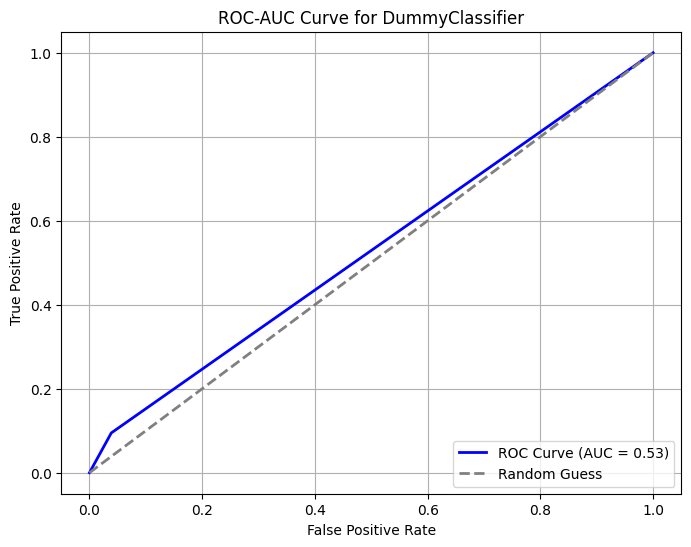

In [3]:
# copying the filtered data frame to avoid modifying the original slice
season_2023_24 = test_df[test_df['Season'] == '2023-24'].copy()

# preparing features for the 2023-24 season
X_2023_24 = season_2023_24[features]

# scaling and imputing features if necessary
X_2023_24_imputed = pd.DataFrame(imputer.transform(X_2023_24), columns=features)
X_2023_24_scaled = pd.DataFrame(scaler.transform(X_2023_24_imputed), columns=features)

# creating MVP_prob to predict probabilities using DummyClassifier
season_2023_24.loc[:, 'MVP_Prob'] = dummy_clf.predict_proba(X_2023_24_scaled)[:, 1]

# taking the top 5
top_5_players = season_2023_24.sort_values(by='MVP_Prob', ascending=False).head(5)
print("Top 5 Players Likely to Win the League MVP Award (2023-24 Season):")
print(top_5_players[['Player', 'Team', 'PTS', 'EFF', 'Team_Rank', 'MVP_Prob']].to_string(index=False))


# getting the actual results
df = nba.get_award_votings('mvp', 2023)
columns = ['Rank', 'Player', 'Age', 'Tm', 'Voting_First']
new_df = df[columns]
print("\nThe actual Top 5 Players nominated for League MVP Award (2023-24 Season):")
print(new_df.head(5))


# getting the predicted probabilities for the positive class
y_pred_proba_test = dummy_clf.predict_proba(X_test_scaled)[:, 1]

# calculating the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

# calculating the area under the curve
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for DummyClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Testing model improvements after implementing Logistic Regression. 

In [4]:
# handling class imbalances using class weights
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# training the model
log_reg.fit(X_train_scaled, y_train)

# predicting on the test set
y_test_pred = log_reg.predict(X_test_scaled)
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# printing out evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print(f"ROC-AUC Score: {roc_auc:.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4879
           1       0.13      0.99      0.23        95

    accuracy                           0.88      4974
   macro avg       0.57      0.93      0.58      4974
weighted avg       0.98      0.88      0.92      4974

ROC-AUC Score: 0.982


Logistic Regression Results Compared to DummyClassifier


With Logistic Regression we achieved an accuracy of 0.88, meaning it correctly predicts 88% of all cases. DummyClassifier had an accuracy of 0.945, which initially seemed impressive but it was largely due to the model's bias toward the majority class (non-mvp candidates).

We were also able to achieve a huge improvment in recall with 0.99 for the minority class (MVP nominees), meaning it identified 99% of the actual MVP nominees! DummyClassifier's recall was only 0.095, identifying a mere 9.5% of actual MVP nominees - this is bad, but expected given the model itself.

Logistic Regression also had an ROC-AUC score of 0.982, indicating excellent separation between the positive and negative classes. DummyClassifier previously scored 0.528, which is only slightly better than randomly guessing. The improvement in ROC-AUC tell us that Logistic Regression is much better at distinguishing MVP nominees from non-nominees.


Top 5 Players Likely to Win the League MVP Award (2023-24 Season):
                 Player Team  PTS  EFF  Team_Rank  MVP_Prob
            Luka Dončić  DAL 33.9 0.53          7  0.999985
            Joel Embiid  PHI 34.7 0.99         12  0.999977
           Nikola Jokić  DEN 26.4 0.49          2  0.999855
  Giannis Antetokounmpo  MIL 30.4 0.50          8  0.999759
Shai Gilgeous-Alexander  OKC 30.1 0.43          3  0.998881

The actual Top 5 Players nominated for League MVP Award (2023-24 Season):
  Rank                   Player  Age   Tm  Voting_First
0    1              Joel Embiid   28  PHI            73
1    2             Nikola Jokić   27  DEN            15
2    3    Giannis Antetokounmpo   28  MIL            12
3    4             Jayson Tatum   24  BOS             0
4    5  Shai Gilgeous-Alexander   24  OKC             0


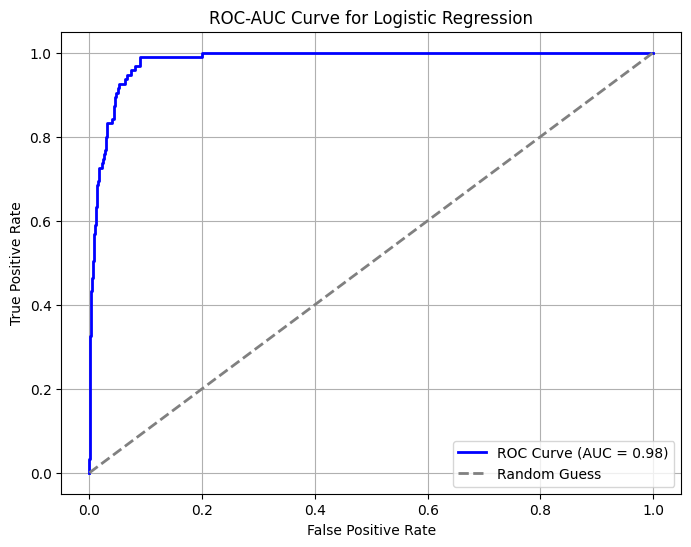

In [5]:
# predicting probabilities for the 2023-24 season and ranking the top 5 players
season_2023_24['MVP_Prob'] = log_reg.predict_proba(X_2023_24_scaled)[:, 1]
top_5_players_lr = season_2023_24.sort_values(by='MVP_Prob', ascending=False).head(5)
print("\nTop 5 Players Likely to Win the League MVP Award (2023-24 Season):")
print(top_5_players_lr[['Player', 'Team', 'PTS', 'EFF', 'Team_Rank', 'MVP_Prob']].to_string(index=False))


# getting the actual results
df = nba.get_award_votings('mvp', 2023)
columns = ['Rank', 'Player', 'Age', 'Tm', 'Voting_First']
new_df = df[columns]
print("\nThe actual Top 5 Players nominated for League MVP Award (2023-24 Season):")
print(new_df.head(5))


# calculating and plotting the ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Lets see how accurate our model was over the last four seasons

In [6]:
# fetching the actual MVP nominees for a given season
def get_actual_mvp_top5(season):
    df = nba.get_award_votings('mvp', int(season[:4]))
    columns = ['Rank', 'Player', 'Age', 'Tm', 'Voting_First']
    actual_df = df[columns]
    return actual_df.head(5)['Player'].tolist()

# this records the accuracy of our prediction (unordered) 
def unordered_top5_accuracy(predicted, actual):
    return len(set(predicted) & set(actual))

seasons = ['2020-21', '2021-22', '2022-23', '2023-24']

for season in seasons:
    actual_top5 = get_actual_mvp_top5(season)
    season_data = test_df[test_df['Season'] == season].copy()

    X_season = season_data[features]
    X_season_imputed = pd.DataFrame(imputer.transform(X_season), columns=features)
    X_season_scaled = pd.DataFrame(scaler.transform(X_season_imputed), columns=features)

    # prediction results
    season_data['MVP_Prob'] = log_reg.predict_proba(X_season_scaled)[:, 1]
    predicted_top5 = season_data.sort_values(by='MVP_Prob', ascending=False).head(5)['Player'].tolist()

    # compare prediction results with actual top 5
    correct_count = unordered_top5_accuracy(predicted_top5, actual_top5)

    print(f"Season: {season}")
    print(f"Predicted Top 5: {', '.join(predicted_top5)}")
    print(f"Actual Top 5: {', '.join(actual_top5)}")
    print(f"Accuracy: {'⭐'*correct_count} ({correct_count}/5)\n")

Season: 2020-21
Predicted Top 5: James Harden, Russell Westbrook, Giannis Antetokounmpo, Nikola Jokić, Luka Dončić
Actual Top 5: Giannis Antetokounmpo, LeBron James, James Harden, Luka Dončić, Kawhi Leonard
Accuracy: ⭐⭐⭐ (3/5)

Season: 2021-22
Predicted Top 5: Luka Dončić, Giannis Antetokounmpo, Nikola Jokić, Joel Embiid, Kevin Durant
Actual Top 5: Nikola Jokić, Joel Embiid, Stephen Curry, Giannis Antetokounmpo, Chris Paul
Accuracy: ⭐⭐⭐ (3/5)

Season: 2022-23
Predicted Top 5: Joel Embiid, Giannis Antetokounmpo, Nikola Jokić, Luka Dončić, Jayson Tatum
Actual Top 5: Nikola Jokić, Joel Embiid, Giannis Antetokounmpo, Devin Booker, Luka Dončić
Accuracy: ⭐⭐⭐⭐ (4/5)

Season: 2023-24
Predicted Top 5: Luka Dončić, Joel Embiid, Nikola Jokić, Giannis Antetokounmpo, Shai Gilgeous-Alexander
Actual Top 5: Joel Embiid, Nikola Jokić, Giannis Antetokounmpo, Jayson Tatum, Shai Gilgeous-Alexander
Accuracy: ⭐⭐⭐⭐ (4/5)



Here's a look at the top 5 MVP contenders as the 2024-25 season stands.

In [7]:
season_2024_25 = test_df[test_df['Season'] == '2024-25'].copy()

X_2024_25 = season_2024_25[features]

X_2024_25_imputed = pd.DataFrame(imputer.transform(X_2024_25), columns=features)
X_2024_25_scaled = pd.DataFrame(scaler.transform(X_2024_25_imputed), columns=features)

season_2024_25['MVP_Prob'] = log_reg.predict_proba(X_2024_25_scaled)[:, 1]

top_5_players_2024_25 = season_2024_25.sort_values(by='MVP_Prob', ascending=False).head(5)

print("\nTop 5 Players Likely to Win the League MVP Award (2024-25 Season):")
print(top_5_players_2024_25[['Player', 'Team', 'PTS', 'EFF', 'Team_Rank', 'MVP_Prob']].to_string(index=False))



Top 5 Players Likely to Win the League MVP Award (2024-25 Season):
                 Player Team  PTS  EFF  Team_Rank  MVP_Prob
           Nikola Jokić  DEN 29.9 2.50         12  0.999974
  Giannis Antetokounmpo  MIL 32.6 1.93         16  0.999922
            Luka Dončić  DAL 28.6 1.73          5  0.999789
           Jayson Tatum  BOS 28.4 1.38          2  0.999677
Shai Gilgeous-Alexander  OKC 29.8 1.39          3  0.999347


While our model is not exactly accurate to real world results, it proves to be another point of view. Showing instead how the MVP ranking should have appeared prioritizing the stats that matter most.